# Model CNN testing

## Carregar les dades

In [1]:
from scipy.io import arff
import pandas as pd
from constants import *

data, _ = arff.loadarff(DATA_DIRECTORY + 'MagicTelescope.arff')
df = pd.DataFrame(data)
df.head(5)

,ID,fLength:,fWidth:,fSize:,fConc:,fConc1:,fAsym:,fM3Long:,fM3Trans:,fAlpha:,fDist:,class:
0,1.0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,b'g'
1,2.0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,b'g'
2,3.0,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,b'g'
3,4.0,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,b'g'
4,5.0,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,b'g'


## Preparar les Dades per al Model

Ara necessitem:
1. **Separar les característiques (X)** - Són les columnes que el model utilitzarà com entrada (totes menys la classe)
2. **Separar l'objectiu (y)** - És el que volem predir (la columna `class:`)
3. **Dividir en entrenament, validació i prova** - El model aprèn amb entrenament, i mesurem el seu rendiment en prova

    **Per què és important:**
    - **Conjunt de prova**: Mai es fa servir durant l'entrenament o la selecció d'hiperparàmetres (només per a l'avaluació final)
    - **Conjunt de validació**: S'utilitza per afinar hiperparàmetres i prevenir sobreajust
    - **Conjunt d'entrenament**: S'utilitza per entrenar el model

    **Estratègia de divisió:**
    - 60% Entrenament
    - 20% Validació
    - 20% Prova
    - Estratificada per mantenir les proporcions de classes

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Dades i output
X = df.drop(columns=['class:'])
y = df['class:']

# Codificar els possibles outputs
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split 80/20% (train+val/test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)
# Split 75/25% de temp (train/val)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

print("Dades:", X_train.shape, X_val.shape, X_test.shape)
print("Classes:", y_train.shape, y_val.shape, y_test.shape)

Dades: (11412, 11) (3804, 11) (3804, 11)
Classes: (11412,) (3804,) (3804,)


## Crear y Entrenar el Modelo: Red Neuronal Artificial (ANN)


!!!!!!!!!!!!! Desenvolupar un argument més sòlid !!!!!!!!!!!!!





Vamos a usar una **Red Neuronal Artificial**, que es como una versión inspirada en el cerebro.

**Por qué ANN:**
- Puede aprender patrones complejos y no lineales ✓
- Se adapta bien a datos desbalanceados con `class_weight` ✓
- Más flexible que Random Forest para ciertos problemas ✓
- Podemos visualizar cómo aprende en cada época ✓

**Estructura:**
- Input layer: 10 características (del telescopio)
- Hidden layers: 2 capas ocultas con activación ReLU (aprenden patrones)
- Output layer: 1 neurona con Sigmoid (para clasificación binaria)

**Manejo del desbalance:**
- Usamos `class_weight='balanced'` en el entrenamiento
- Esto hace que el modelo penalice más los errores en la clase minoritaria

In [3]:
import torch
from sklearn.preprocessing import StandardScaler

# Normalitzar les dades
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train) # Normalitzem train
X_val_scaled = scaler_final.transform(X_val) # Normalitzem val amb els paràmetres de train
X_test_scaled = scaler_final.transform(X_test) # Normalitzem test amb els paràmetres de train

# Convertir a tensors de torch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calcular els pesos de cada classe per evitar desbalanceig
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

for class_label, weight in class_weight_dict.items():
    print(f"  Clase {class_label}: {weight:.4f}")

  Clase 0: 0.7711
  Clase 1: 1.4222


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleANN(nn.Module):
    def __init__(self, input_dim, hidden_size=5):
        super(SimpleANN, self).__init__()
        # Capa oculta: fully connected
        self.fc1 = nn.Linear(input_dim, hidden_size)  # 5 neuronas en la capa oculta
        # Capa de salida: fully connected
        self.fc2 = nn.Linear(hidden_size, 1)          # 1 neurona para salida binaria

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)   # SIN sigmoid porque ya lo hace el criterion
        return x

In [6]:
def train_model(
        model, criterion, optimizer, X_train_tensor, y_train_tensor,
        X_val_tensor, y_val_tensor, epochs=1000, patience=None, print_progress=True
    ):

    losses = {'train': [], 'val': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Entrenament
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses['train'].append(loss.item())
        
        # Validació
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            losses['val'].append(val_loss.item())
        
        # Early stopping (if patience)
        if patience is not None:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else: patience_counter += 1
            
            if patience_counter >= patience:
                if print_progress: print(f"Early stopping at epoch {epoch}")
                break
        
        if (epoch % (epochs // 10) == 0 or epoch == epochs - 1) and print_progress:
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
    
    return losses

In [7]:
import matplotlib.pyplot as plt

def plot_training_history(losses_dict, show_best_epoch=False):
    if show_best_epoch:
        pos = losses_dict['val'].index(min(losses_dict['val']))
        print(f"Best epoch: {pos}, Train Loss: {losses_dict['train'][pos]:.4f}, Val Loss: {losses_dict['val'][pos]:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(losses_dict['train'], label='Train Loss', linewidth=2)
    plt.plot(losses_dict['val'], label='Validation Loss', linewidth=2)
    
    if show_best_epoch:
        plt.axvline(x=pos, color='red', linestyle='--', linewidth=2, label='Best Epoch')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Training and Validation Loss Evolution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Epoch 0, Train Loss: 0.6380, Val Loss: 0.6376
Epoch 10000, Train Loss: 0.0040, Val Loss: 0.0076
Epoch 20000, Train Loss: 0.0002, Val Loss: 0.0105
Epoch 30000, Train Loss: 0.0000, Val Loss: 0.0200
Epoch 40000, Train Loss: 0.0000, Val Loss: 0.0315
Epoch 50000, Train Loss: 0.0000, Val Loss: 0.0390
Epoch 60000, Train Loss: 0.0000, Val Loss: 0.0421
Epoch 70000, Train Loss: 0.0000, Val Loss: 0.0453
Epoch 80000, Train Loss: 0.0000, Val Loss: 0.0472
Epoch 90000, Train Loss: 0.0000, Val Loss: 0.0483
Epoch 99999, Train Loss: 0.0000, Val Loss: 0.0488
Best epoch: 12240, Train Loss: 0.0021, Val Loss: 0.0062


Epoch 0, Train Loss: 0.6380, Val Loss: 0.6376
Epoch 10000, Train Loss: 0.0040, Val Loss: 0.0076
Epoch 20000, Train Loss: 0.0002, Val Loss: 0.0105
Epoch 30000, Train Loss: 0.0000, Val Loss: 0.0200
Epoch 40000, Train Loss: 0.0000, Val Loss: 0.0315
Epoch 50000, Train Loss: 0.0000, Val Loss: 0.0390
Epoch 60000, Train Loss: 0.0000, Val Loss: 0.0421
Epoch 70000, Train Loss: 0.0000, Val Loss: 0.0453
Epoch 80000, Train Loss: 0.0000, Val Loss: 0.0472
Epoch 90000, Train Loss: 0.0000, Val Loss: 0.0483
Epoch 99999, Train Loss: 0.0000, Val Loss: 0.0488
Best epoch: 12240, Train Loss: 0.0021, Val Loss: 0.0062


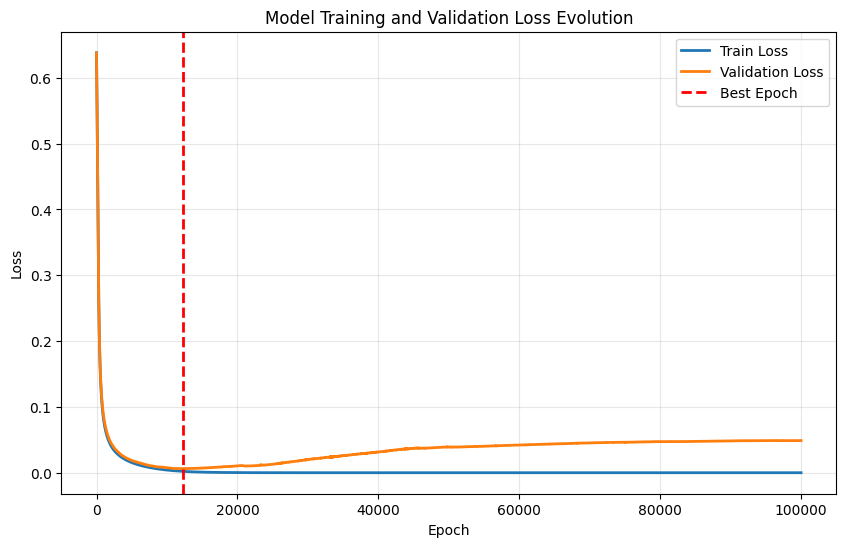

In [8]:
model = SimpleANN(input_dim = X_train_scaled.shape[1])

train_losses_dict = train_model(
    model = model,
    criterion = torch.nn.BCEWithLogitsLoss(),
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001),
    X_train_tensor = X_train_tensor,
    y_train_tensor = y_train_tensor,
    X_val_tensor = X_val_tensor,
    y_val_tensor = y_val_tensor,
    epochs=100000
)

plot_training_history(train_losses_dict, show_best_epoch=True)

In [9]:
impatient_model = SimpleANN(input_dim = X_train_scaled.shape[1])

train_losses_dict = train_model(
    model = impatient_model,
    criterion = torch.nn.BCEWithLogitsLoss(),
    optimizer = torch.optim.Adam(impatient_model.parameters(), lr=0.001),
    X_train_tensor = X_train_tensor,
    y_train_tensor = y_train_tensor,
    X_val_tensor = X_val_tensor,
    y_val_tensor = y_val_tensor,
    epochs=100000,
    patience=50
)

Epoch 0, Train Loss: 0.7485, Val Loss: 0.7475
Early stopping at epoch 7571


El paràmetre paciència sembla funcionar correctament

In [10]:
def plot_accuracy(df):
    plt.figure(figsize=(10, 6))
    plt.plot(df['hidden_size'], df['train_accuracy'], marker='o', label='Train')
    plt.plot(df['hidden_size'], df['test_accuracy'], marker='o', label='Test')
    plt.xscale('log', base=2)
    plt.xlabel('hidden_size')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs hidden_size')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [11]:
complexity_sizes = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

accuracy_results = []

for hidden_size in complexity_sizes:
    custom_model = SimpleANN(input_dim = X_train_scaled.shape[1], hidden_size=hidden_size)

    train_losses_dict = train_model(
        model = custom_model,
        criterion = torch.nn.BCEWithLogitsLoss(),
        optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001),
        X_train_tensor = X_train_tensor,
        y_train_tensor = y_train_tensor,
        X_val_tensor = X_val_tensor,
        y_val_tensor = y_val_tensor,
        epochs=1000,
        patience=50,
        print_progress=False
    )

    custom_model.eval()
    with torch.no_grad():
        train_logits = custom_model(X_train_tensor)
        train_probs = torch.sigmoid(train_logits)
        train_preds = (train_probs > 0.5).float()
        train_acc = (train_preds == y_train_tensor).float().mean().item()

        test_logits = custom_model(X_test_tensor)
        test_probs = torch.sigmoid(test_logits)
        test_preds = (test_probs > 0.5).float()
        test_acc = (test_preds == y_test_tensor).float().mean().item()

    accuracy_results.append({
        'hidden_size': hidden_size,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })
    print(f"Hidden Size: {hidden_size}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

accuracy_results_df = pd.DataFrame(accuracy_results)

Hidden Size: 4, Train Accuracy: 0.9784, Test Accuracy: 0.9787
Hidden Size: 8, Train Accuracy: 0.9798, Test Accuracy: 0.9795
Hidden Size: 16, Train Accuracy: 0.9888, Test Accuracy: 0.9884
Hidden Size: 32, Train Accuracy: 0.9920, Test Accuracy: 0.9913
Hidden Size: 64, Train Accuracy: 0.9935, Test Accuracy: 0.9929
Hidden Size: 128, Train Accuracy: 0.9953, Test Accuracy: 0.9934
Hidden Size: 256, Train Accuracy: 0.9969, Test Accuracy: 0.9947
Hidden Size: 512, Train Accuracy: 0.9986, Test Accuracy: 0.9958
Hidden Size: 1024, Train Accuracy: 0.9993, Test Accuracy: 0.9963
Hidden Size: 2048, Train Accuracy: 1.0000, Test Accuracy: 0.9961


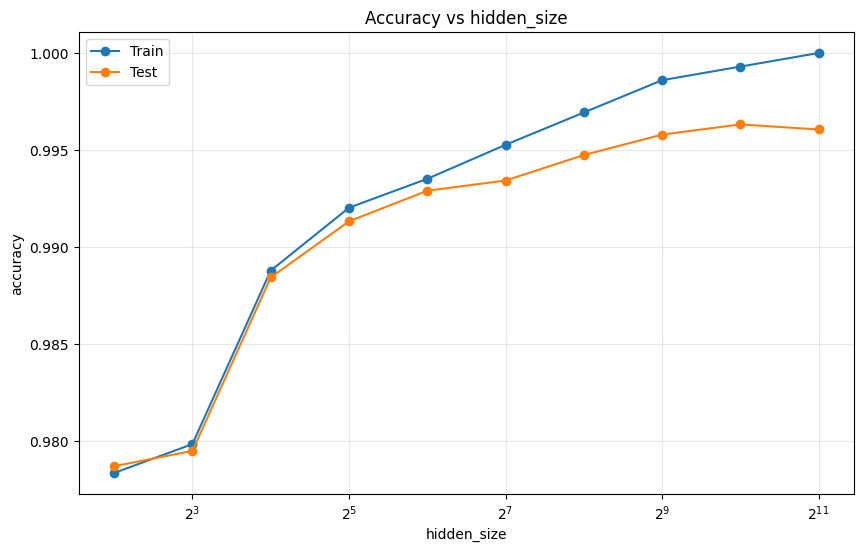

In [12]:
plot_accuracy(accuracy_results_df)

In [13]:
sample_sizes = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]
sample_results = []

for size_fraction in sample_sizes:
    n_samples = int(len(X_train_tensor) * size_fraction)
    indices = torch.randperm(len(X_train_tensor))[:n_samples]
    X_train_subset = X_train_tensor[indices]
    y_train_subset = y_train_tensor[indices]

    custom_model = SimpleANN(input_dim = X_train_scaled.shape[1], hidden_size=64)

    train_losses_dict = train_model(
        model = custom_model,
        criterion = torch.nn.BCEWithLogitsLoss(),
        optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001),
        X_train_tensor = X_train_subset,
        y_train_tensor = y_train_subset,
        X_val_tensor = X_val_tensor,
        y_val_tensor = y_val_tensor,
        epochs=1000,
        patience=50,
        print_progress=False
    )

    custom_model.eval()
    with torch.no_grad():
        train_logits = custom_model(X_train_subset)
        train_probs = torch.sigmoid(train_logits)
        train_preds = (train_probs > 0.5).float()
        train_acc = (train_preds == y_train_subset).float().mean().item()

        test_logits = custom_model(X_test_tensor)
        test_probs = torch.sigmoid(test_logits)
        test_preds = (test_probs > 0.5).float()
        test_acc = (test_preds == y_test_tensor).float().mean().item()

    sample_results.append({
        'sample_size': size_fraction,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })
    print(f"Sample Size: {size_fraction}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    
sample_results_df = pd.DataFrame(sample_results)

Sample Size: 0.05, Train Accuracy: 1.0000, Test Accuracy: 0.9853
Sample Size: 0.1, Train Accuracy: 0.9991, Test Accuracy: 0.9861
Sample Size: 0.2, Train Accuracy: 0.9965, Test Accuracy: 0.9905
Sample Size: 0.3, Train Accuracy: 0.9950, Test Accuracy: 0.9913
Sample Size: 0.4, Train Accuracy: 0.9954, Test Accuracy: 0.9913
Sample Size: 0.5, Train Accuracy: 0.9944, Test Accuracy: 0.9919
Sample Size: 0.6, Train Accuracy: 0.9939, Test Accuracy: 0.9924
Sample Size: 0.7, Train Accuracy: 0.9937, Test Accuracy: 0.9913
Sample Size: 0.8, Train Accuracy: 0.9935, Test Accuracy: 0.9916
Sample Size: 0.9, Train Accuracy: 0.9937, Test Accuracy: 0.9926
Sample Size: 1.0, Train Accuracy: 0.9933, Test Accuracy: 0.9924


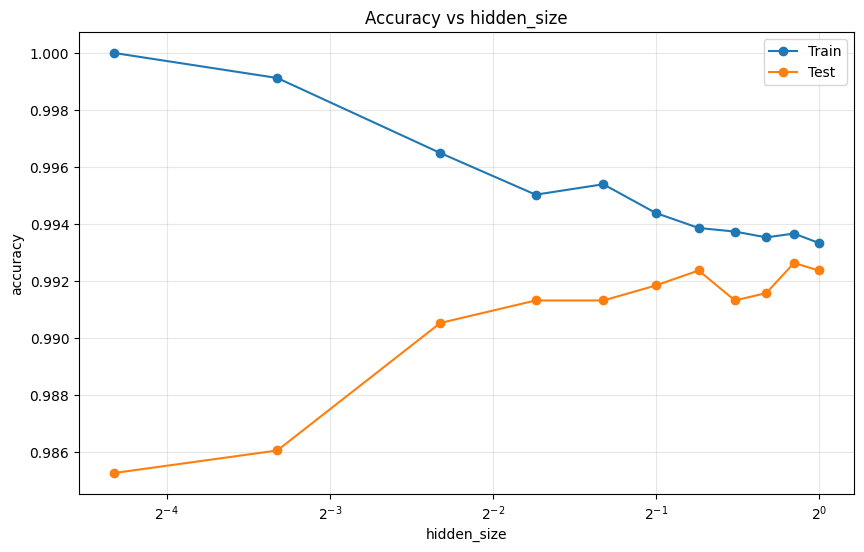

In [14]:
plot_accuracy(sample_results_df.rename(columns={'sample_size': 'hidden_size'}))

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

model.eval()

with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits)
    predictions = (probs > 0.5).float()

# Convertir predictions i ground truth a numpy arrays
y_pred = predictions.numpy().flatten()
y_true = y_test_tensor.numpy().flatten()

# Calcular mètriques
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, probs.numpy().flatten())
cm = confusion_matrix(y_true, y_pred)

# Mostrar resultats
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")

Accuracy:  0.9984
Precision: 0.9985
Recall:    0.9970
F1-Score:  0.9978
ROC-AUC:   1.0000

Confusion Matrix:
[[2464    2]
 [   4 1334]]


## SSL setup: transformar MagicTelescope en problema semi-supervisado

Usamos un esquema MCAR (Missing Completely At Random) estratificado para ocultar etiquetas.
Esto crea un conjunto con una fraccion de ejemplos etiquetados y el resto sin etiqueta.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def make_unlabeled_random_stratified(y, proportion, random_state=42):
    if not (0 < proportion <= 1):
        raise ValueError("proportion must be in (0, 1].")

    y = np.asarray(y)
    indices = np.arange(len(y))

    if proportion == 1:
        return np.ones(len(y), dtype=bool)

    labeled_idx, _ = train_test_split(
        indices,
        train_size=proportion,
        stratify=y,
        random_state=random_state
    )
    labeled_mask = np.zeros(len(y), dtype=bool)
    labeled_mask[labeled_idx] = True
    return labeled_mask

# Convert to numpy for SSL experiments
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

In [36]:
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def self_training(model, X_l, y_l, X_u, threshold=0.9, max_iter=10):
    model = clone(model)
    X_l = np.asarray(X_l)
    y_l = np.asarray(y_l)
    X_u = np.asarray(X_u)

    for _ in range(max_iter):
        model.fit(X_l, y_l)
        if X_u.shape[0] == 0:
            break
        probs = model.predict_proba(X_u)
        conf = np.max(probs, axis=1)
        pseudo = np.argmax(probs, axis=1)
        keep = conf >= threshold
        if not np.any(keep):
            break
        X_l = np.vstack([X_l, X_u[keep]])
        y_l = np.concatenate([y_l, pseudo[keep]])
        X_u = X_u[~keep]

    model.fit(X_l, y_l)
    return model

def evaluate_model(model, X_test, y_test):
    probs = model.predict_proba(X_test)[:, 1]
    preds = (probs >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_test, preds),
        "f1": f1_score(y_test, preds),
        "roc_auc": roc_auc_score(y_test, probs)
    }

base_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, class_weight="balanced")
)

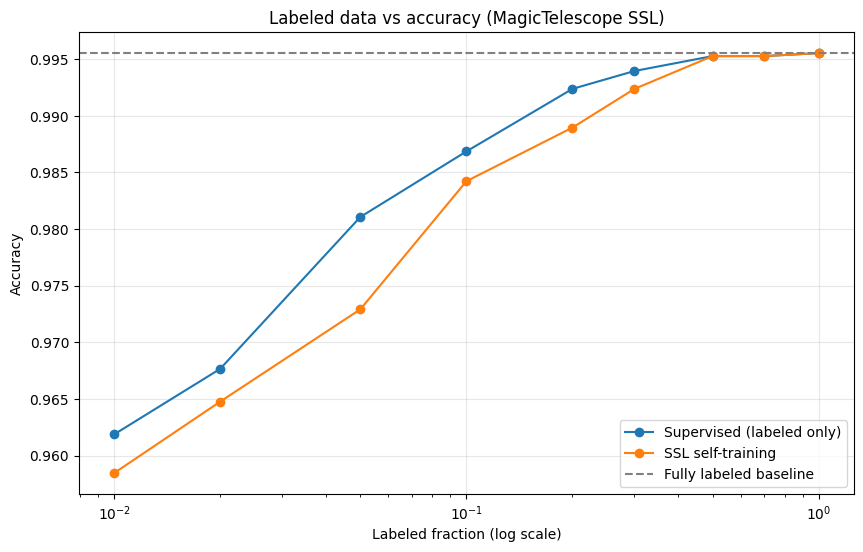

In [39]:
# Fractions of labeled data to study
fractions = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]

# Fully labeled baseline
full_model = clone(base_model).fit(X_train_np, y_train_np)
full_metrics = evaluate_model(full_model, X_test_np, y_test_np)

results = []

for p in fractions:
    labeled_mask = make_unlabeled_random_stratified(y_train_np, p, random_state=42)
    X_l, y_l = X_train_np[labeled_mask], y_train_np[labeled_mask]
    X_u = X_train_np[~labeled_mask]

    supervised_model = clone(base_model).fit(X_l, y_l)
    ssl_model = self_training(base_model, X_l, y_l, X_u, threshold=0.9, max_iter=10)

    sup_metrics = evaluate_model(supervised_model, X_test_np, y_test_np)
    ssl_metrics = evaluate_model(ssl_model, X_test_np, y_test_np)

    results.append({
        "labeled_fraction": p,
        "accuracy_supervised": sup_metrics["accuracy"],
        "accuracy_ssl": ssl_metrics["accuracy"],
        "f1_supervised": sup_metrics["f1"],
        "f1_ssl": ssl_metrics["f1"],
        "roc_auc_supervised": sup_metrics["roc_auc"],
        "roc_auc_ssl": ssl_metrics["roc_auc"]
    })

results_df = pd.DataFrame(results)
results_df

plt.figure(figsize=(10, 6))
plt.plot(results_df["labeled_fraction"], results_df["accuracy_supervised"], marker="o", label="Supervised (labeled only)")
plt.plot(results_df["labeled_fraction"], results_df["accuracy_ssl"], marker="o", label="SSL self-training")
plt.axhline(full_metrics["accuracy"], color="gray", linestyle="--", label="Fully labeled baseline")
plt.xscale("log")
plt.xlabel("Labeled fraction (log scale)")
plt.ylabel("Accuracy")
plt.title("Labeled data vs accuracy (MagicTelescope SSL)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Analisis del numero de etiquetas

- Describe la tendencia de la curva SSL vs supervisado.
- Indica a partir de que fraccion de etiquetas la curva se estabiliza.
- Compara contra el rendimiento con datos totalmente etiquetados (linea discontinua).
- Si la SSL mejora claramente con pocas etiquetas, explica por que puede pasar.

In [49]:
def self_training_with_history(model, X_l, y_l, X_u, X_test, y_test, threshold=0.9, max_iter=10):
    """
    Self-training que registra el accuracy en cada iteración
    """
    model = clone(model)
    X_l = np.asarray(X_l)
    y_l = np.asarray(y_l)
    X_u = np.asarray(X_u)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)

    history = {
        'iteration': [0],  # Iteración inicial
        'accuracy': [],
        'labeled_count': [len(y_l)],
        'unlabeled_count': [len(X_u)]  # Cantidad de datos sin etiquetar
    }

    # Evaluar modelo inicial
    probs_initial = model.fit(X_l, y_l).predict_proba(X_test)[:, 1]
    preds_initial = (probs_initial >= 0.5).astype(int)
    acc_initial = accuracy_score(y_test, preds_initial)
    history['accuracy'].append(acc_initial)

    for iteration in range(1, max_iter + 1):
        model.fit(X_l, y_l)
        if X_u.shape[0] == 0:
            break

        probs = model.predict_proba(X_u)
        conf = np.max(probs, axis=1)
        pseudo = np.argmax(probs, axis=1)
        keep = conf >= threshold

        if not np.any(keep):
            break

        X_l = np.vstack([X_l, X_u[keep]])
        y_l = np.concatenate([y_l, pseudo[keep]])
        X_u = X_u[~keep]

        # Evaluar en cada iteración
        probs_test = model.predict_proba(X_test)[:, 1]
        preds_test = (probs_test >= 0.5).astype(int)
        acc = accuracy_score(y_test, preds_test)

        history['iteration'].append(iteration)
        history['accuracy'].append(acc)
        history['labeled_count'].append(len(y_l))
        history['unlabeled_count'].append(len(X_u))

    return model, history

In [50]:
# Experimento: cómo evoluciona el accuracy a medida que Self-Training añade más datos pseudo-etiquetados
# Para 3 fracciones diferentes: 10%, 20%, 30%

results_evolution = {}
labeled_fractions = [0.1, 0.2, 0.3]

for frac in labeled_fractions:
    labeled_mask = make_unlabeled_random_stratified(y_train_np, frac, random_state=42)
    X_l, y_l = X_train_np[labeled_mask], y_train_np[labeled_mask]
    X_u = X_train_np[~labeled_mask]

    _, history = self_training_with_history(
        base_model,
        X_l, y_l, X_u,
        X_test_np, y_test_np,
        threshold=0.9,
        max_iter=10
    )

    results_evolution[f"{int(frac*100)}%"] = history
    print(f"\nFracción {int(frac*100)}% etiquetada:")
    print(f"  Datos etiquetados iniciales: {history['labeled_count'][0]}")
    print(f"  Datos etiquetados finales: {history['labeled_count'][-1]}")
    print(f"  Accuracy inicial: {history['accuracy'][0]:.4f}")
    print(f"  Accuracy final: {history['accuracy'][-1]:.4f}")



Fracción 10% etiquetada:
  Datos etiquetados iniciales: 1141
  Datos etiquetados finales: 10820
  Accuracy inicial: 0.9869
  Accuracy final: 0.9842

Fracción 20% etiquetada:
  Datos etiquetados iniciales: 2282
  Datos etiquetados finales: 10849
  Accuracy inicial: 0.9924
  Accuracy final: 0.9892

Fracción 30% etiquetada:
  Datos etiquetados iniciales: 3423
  Datos etiquetados finales: 10891
  Accuracy inicial: 0.9940
  Accuracy final: 0.9926


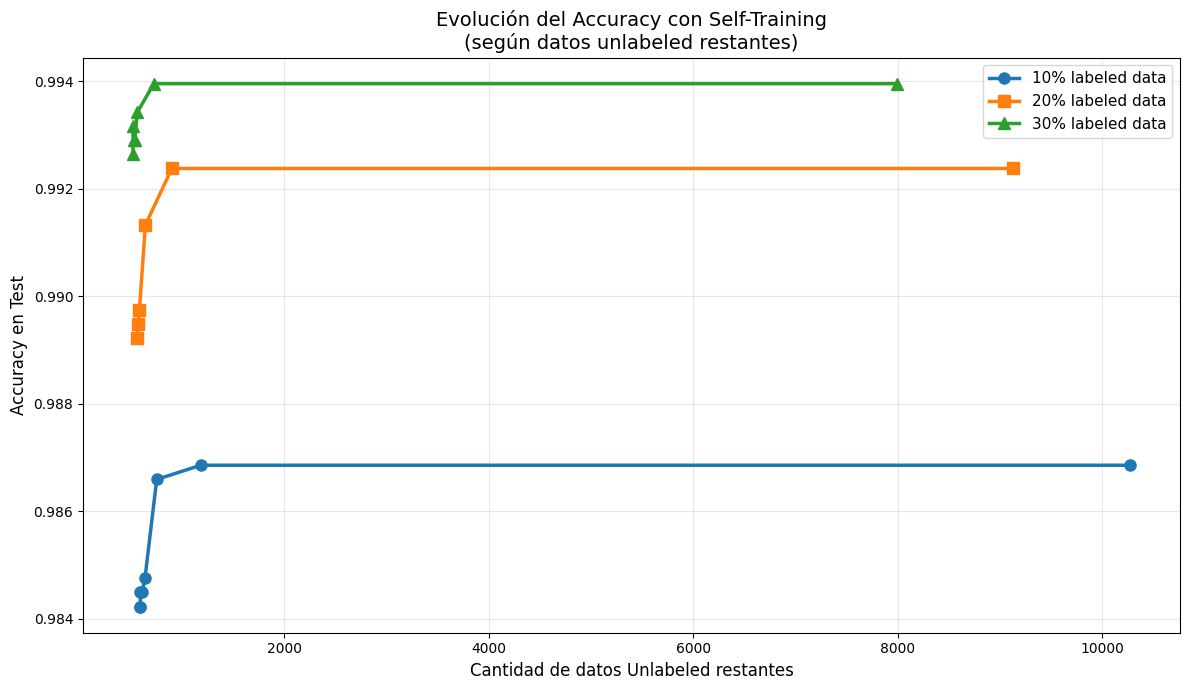


RESUMEN DE LA EVOLUCIÓN

10% labeled data:
  Accuracy inicial: 0.9869
  Accuracy final:   0.9842
  Mejora:           -0.0026 (-0.27%)
  Datos unlabeled iniciales: 10271
  Datos unlabeled finales:   592
  Iteraciones completadas: 7

20% labeled data:
  Accuracy inicial: 0.9924
  Accuracy final:   0.9892
  Mejora:           -0.0032 (-0.32%)
  Datos unlabeled iniciales: 9130
  Datos unlabeled finales:   563
  Iteraciones completadas: 5

30% labeled data:
  Accuracy inicial: 0.9940
  Accuracy final:   0.9926
  Mejora:           -0.0013 (-0.13%)
  Datos unlabeled iniciales: 7989
  Datos unlabeled finales:   521
  Iteraciones completadas: 6


In [53]:
# Graficar la evolución del accuracy para cada fracción
plt.figure(figsize=(12, 7))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's', '^']

for idx, (label, history) in enumerate(results_evolution.items()):
    plt.plot(
        history['unlabeled_count'],
        history['accuracy'],
        marker=markers[idx],
        linewidth=2.5,
        markersize=8,
        label=f"{label} labeled data",
        color=colors[idx]
    )

plt.xlabel('Cantidad de datos Unlabeled restantes', fontsize=12)
plt.ylabel('Accuracy en Test', fontsize=12)
plt.title('Evolución del Accuracy con Self-Training\n(según datos unlabeled restantes)', fontsize=14)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar resumen
print("\n" + "="*70)
print("RESUMEN DE LA EVOLUCIÓN")
print("="*70)
for label, history in results_evolution.items():
    improvement = history['accuracy'][-1] - history['accuracy'][0]
    print(f"\n{label} labeled data:")
    print(f"  Accuracy inicial: {history['accuracy'][0]:.4f}")
    print(f"  Accuracy final:   {history['accuracy'][-1]:.4f}")
    print(f"  Mejora:           {improvement:+.4f} ({improvement/history['accuracy'][0]*100:+.2f}%)")
    print(f"  Datos unlabeled iniciales: {history['unlabeled_count'][0]}")
    print(f"  Datos unlabeled finales:   {history['unlabeled_count'][-1]}")
    print(f"  Iteraciones completadas: {len(history['iteration'])-1}")
